In [2]:
print("hi")

hi


In [3]:
"""
Enterprise Trading Signal Generation System
==========================================

A comprehensive trading system for generating signals, backtesting strategies,
and visualizing trading performance with enterprise-grade code quality.

Author: Trading Systems Team
Version: 1.0.0
Date: 2024-10-28
"""

import os
import logging
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Union, Any
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.patches as mpatches

# Custom imports - ensure these are properly installed
try:
    from bktst import EnterpriseTradingFramework
    from resampler import EnterpriseDataResampler
    from tafm import create_analyzer, IndicatorConfig
    from ChartterX5 import Chartter
except ImportError as e:
    logging.error(f"Failed to import custom modules: {e}")
    raise


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [4]:
@dataclass
class TradingConfig:
    """
    Configuration class for trading system parameters.

    This centralized configuration ensures all trading parameters are
    easily maintainable and version-controlled.
    """

    # Technical Analysis Parameters
    rsi_period: int = 14
    ema_period: int = 15

    # Risk Management Parameters
    stop_loss_multiplier: float = 1.0
    take_profit_multiplier: float = 2.0
    commission: float = 0.0

    # Data Parameters
    start_date: str = "2024-10-01"
    end_date: str = "2024-10-02"
    timeframe: str = "1T"  # 1 minute

    # File Paths
    data_path: str = "./src/"
    input_filename: str = "ohlcv-1M-mt5.parquet"
    output_filename: str = "signal_analysis_results.parquet"

    # Chart Configuration
    chart_width: int = 20
    chart_height: int = 8
    max_candles_display: int = 300

    # Validation Parameters
    min_candles_required: int = 50
    max_missing_data_pct: float = 5.0  # Maximum 5% missing data allowed

    def __post_init__(self):
        """Validate configuration parameters after initialization."""
        self._validate_config()

    def _validate_config(self) -> None:
        """
        Validate configuration parameters for logical consistency.

        Raises:
            ValueError: If any configuration parameter is invalid
        """
        if self.rsi_period <= 0:
            raise ValueError("RSI period must be positive")
        if self.ema_period <= 0:
            raise ValueError("EMA period must be positive")
        if self.stop_loss_multiplier < 0:
            raise ValueError("Stop loss multiplier cannot be negative")
        if self.take_profit_multiplier <= 0:
            raise ValueError("Take profit multiplier must be positive")
        if self.commission < 0:
            raise ValueError("Commission cannot be negative")



In [5]:
class DataValidator:
    """
    Comprehensive data validation utilities for OHLCV data.

    Ensures data quality and integrity before processing.
    """

    REQUIRED_COLUMNS = ['open', 'high', 'low', 'close', 'volume']

    @classmethod
    def validate_ohlcv_data(
        cls,
        df: pd.DataFrame,
        config: TradingConfig
    ) -> pd.DataFrame:
        """
        Comprehensive validation of OHLCV data.

        Args:
            df: DataFrame containing OHLCV data
            config: Trading configuration object

        Returns:
            Validated and cleaned DataFrame

        Raises:
            ValueError: If data validation fails

        Example:
            >>> validator = DataValidator()
            >>> clean_data = validator.validate_ohlcv_data(raw_data, config)
        """
        logger.info("Starting OHLCV data validation...")

        # Check required columns
        cls._check_required_columns(df)

        # Validate data types
        cls._validate_data_types(df)

        # Check for data quality issues
        cls._check_data_quality(df)

        # Validate minimum data requirements
        cls._check_minimum_data_requirements(df, config)

        # Check for missing data
        cls._check_missing_data(df, config)

        logger.info(f"Data validation completed. Shape: {df.shape}")
        return df

    @classmethod
    def _check_required_columns(cls, df: pd.DataFrame) -> None:
        """Check if all required columns are present."""
        missing_columns = [col for col in cls.REQUIRED_COLUMNS if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

    @classmethod
    def _validate_data_types(cls, df: pd.DataFrame) -> None:
        """Validate that numeric columns contain numeric data."""
        numeric_columns = ['open', 'high', 'low', 'close', 'volume']
        for col in numeric_columns:
            if not pd.api.types.is_numeric_dtype(df[col]):
                raise ValueError(f"Column '{col}' must contain numeric data")

    @classmethod
    def _check_data_quality(cls, df: pd.DataFrame) -> None:
        """Check for basic OHLCV data quality issues."""
        # Check for invalid OHLC relationships
        invalid_high_low = (df['high'] < df['low']).any()
        if invalid_high_low:
            raise ValueError("Invalid OHLCV data: high < low detected")

        invalid_ohlc = (
            (df['open'] > df['high']) |
            (df['open'] < df['low']) |
            (df['close'] > df['high']) |
            (df['close'] < df['low'])
        ).any()
        if invalid_ohlc:
            raise ValueError("Invalid OHLCV data: open/close outside high/low range")

        # Check for negative values (except returns)
        price_columns = ['open', 'high', 'low', 'close']
        for col in price_columns:
            if (df[col] <= 0).any():
                warnings.warn(f"Zero or negative values found in {col}")

        if (df['volume'] < 0).any():
            raise ValueError("Negative volume values detected")

    @classmethod
    def _check_minimum_data_requirements(cls, df: pd.DataFrame, config: TradingConfig) -> None:
        """Check if sufficient data is available for analysis."""
        if len(df) < config.min_candles_required:
            raise ValueError(
                f"Insufficient data: {len(df)} candles, "
                f"minimum required: {config.min_candles_required}"
            )

    @classmethod
    def _check_missing_data(cls, df: pd.DataFrame, config: TradingConfig) -> None:
        """Check for excessive missing data."""
        missing_pct = (df.isnull().sum() / len(df) * 100).max()
        if missing_pct > config.max_missing_data_pct:
            raise ValueError(
                f"Too much missing data: {missing_pct:.2f}%, "
                f"maximum allowed: {config.max_missing_data_pct}%"
            )


In [6]:
class DataProcessor:
    """
    High-level data processing operations for trading data.

    Handles data loading, resampling, and preparation for analysis.
    """

    def __init__(self, config: TradingConfig):
        """
        Initialize data processor.

        Args:
            config: Trading configuration object
        """
        self.config = config
        self.resampler = EnterpriseDataResampler()
        logger.info("DataProcessor initialized")

    def load_and_prepare_data(self) -> pd.DataFrame:
        """
        Load and prepare trading data for analysis.

        Returns:
            Processed and validated DataFrame ready for analysis

        Raises:
            FileNotFoundError: If data file is not found
            ValueError: If data validation fails

        Example:
            >>> processor = DataProcessor(config)
            >>> data = processor.load_and_prepare_data()
        """
        try:
            # Load data
            data = self._load_raw_data()

            # Standardize column names
            data = self._standardize_columns(data)

            # Validate data quality
            data = DataValidator.validate_ohlcv_data(data, self.config)

            # Apply filters and resampling
            data = self._apply_data_filters(data)

            # Prepare for analysis
            data = self._prepare_for_analysis(data)

            logger.info(f"Data preparation completed. Final shape: {data.shape}")
            return data

        except Exception as e:
            logger.error(f"Data preparation failed: {e}")
            raise

    def _load_raw_data(self) -> pd.DataFrame:
        """Load raw OHLCV data from file."""
        file_path = Path(self.config.data_path) / self.config.input_filename

        if not file_path.exists():
            raise FileNotFoundError(f"Data file not found: {file_path}")

        logger.info(f"Loading data from: {file_path}")
        data = pd.read_parquet(file_path)
        logger.info(f"Raw data loaded. Shape: {data.shape}")

        return data

    def _standardize_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Standardize column names to consistent format.

        Args:
            df: Raw DataFrame with potentially inconsistent column names

        Returns:
            DataFrame with standardized column names
        """
        # Common column name mappings
        column_mapping = {
            'tickvol': 'volume',  # MT5 specific
            'tick_volume': 'volume',
            'vol': 'volume',
        }

        # Apply mappings
        df = df.rename(columns=column_mapping)

        # Ensure lowercase column names
        df.columns = df.columns.str.lower()

        logger.info("Column names standardized")
        return df

    def _apply_data_filters(self, df: pd.DataFrame) -> pd.DataFrame:
        """Apply date range and business hour filters."""
        # Apply date filtering
        filtered_data = self.resampler.date_filter.filter_by_date_range(
            df,
            start_date=self.config.start_date,
            end_date=self.config.end_date
        )

        # Apply business data filtering
        filtered_data = self.resampler.filter_business_data(
            filtered_data,
            business_hours_only=False,  # Keep all hours for forex data
            weekdays_only=True  # Remove weekends
        )

        # Resample to desired timeframe
        resampled_data = self.resampler.resample_data(
            filtered_data,
            period=self.config.timeframe
        )

        logger.info(f"Data filtering completed. Shape: {resampled_data.shape}")
        return resampled_data

    def _prepare_for_analysis(self, df: pd.DataFrame) -> pd.DataFrame:
        """Prepare data for technical analysis."""
        # Set datetime index
        if 'datetime' in df.columns:
            df = df.set_index('datetime')

        # Ensure proper column naming for technical analysis
        df = df.rename(columns={
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
            'volume': 'Volume'
        })

        return df


In [7]:
class SignalGenerator:
    """
    Advanced signal generation system with multiple strategies.

    Generates trading signals based on technical indicators and provides
    comprehensive signal analysis capabilities.
    """

    def __init__(self, config: TradingConfig):
        """
        Initialize signal generator.

        Args:
            config: Trading configuration object
        """
        self.config = config
        self.analyzer = None
        logger.info("SignalGenerator initialized")

    def generate_rsi_ema_signals(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Generate trading signals based on RSI crossing above its EMA.

        Strategy Logic:
        - Calculate RSI with specified period
        - Calculate EMA of RSI with specified period
        - Generate BUY signal when RSI crosses above its EMA

        Args:
            df: OHLCV DataFrame with proper column names

        Returns:
            DataFrame with indicators and signals added

        Example:
            >>> generator = SignalGenerator(config)
            >>> signals_df = generator.generate_rsi_ema_signals(data)
        """
        logger.info("Generating RSI-EMA crossover signals...")

        try:
            # Create technical analysis framework
            self.analyzer = create_analyzer(df.copy())

            # Add RSI indicator
            self.analyzer.add_indicator(
                IndicatorConfig(
                    name='RSI',
                    period=self.config.rsi_period,
                    source_column='Close'
                )
            )

            # Add EMA of RSI
            rsi_column = f'RSI_{self.config.rsi_period}'
            ema_column = f'EMA_{self.config.ema_period}'

            self.analyzer.add_indicator(
                IndicatorConfig(
                    name='EMA',
                    period=self.config.ema_period,
                    source_column=rsi_column
                )
            )

            # Generate crossover signals
            signal_column = f'{rsi_column}_crossed_up_{ema_column}'
            self.analyzer.crossed_up(rsi_column, ema_column)

            # Get results
            result_df = self.analyzer.df.copy()

            # Add signal summary
            signal_count = result_df[signal_column].sum()
            logger.info(f"Generated {signal_count} RSI-EMA crossover signals")

            return result_df

        except Exception as e:
            logger.error(f"Signal generation failed: {e}")
            raise

    def calculate_risk_reward_levels(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculate stop loss and take profit levels for each candle.

        Method:
        - Stop Loss: Low - (High - Low) * stop_loss_multiplier
        - Take Profit: Close + (High - Low) * take_profit_multiplier

        Args:
            df: DataFrame with OHLC data

        Returns:
            DataFrame with SL and TP columns added

        Example:
            >>> df_with_levels = generator.calculate_risk_reward_levels(df)
        """
        logger.info("Calculating risk-reward levels...")

        df = df.copy()

        # Calculate candle range (High - Low)
        candle_range = df['High'] - df['Low']

        # Calculate Stop Loss level
        df['SL'] = df['Low'] - (candle_range * self.config.stop_loss_multiplier)

        # Calculate Take Profit level
        df['TP'] = df['Close'] + (candle_range * self.config.take_profit_multiplier)

        # Add risk-reward ratio
        df['RR_Ratio'] = (df['TP'] - df['Close']) / (df['Close'] - df['SL'])

        logger.info("Risk-reward levels calculated successfully")
        return df

    def extract_signal_data(self, df: pd.DataFrame, signal_column: str) -> np.ndarray:
        """
        Extract structured signal data for visualization and backtesting.

        Args:
            df: DataFrame with signals and risk-reward levels
            signal_column: Name of the signal column

        Returns:
            Structured numpy array with signal information

        Example:
            >>> signal_data = generator.extract_signal_data(df, 'RSI_14_crossed_up_EMA_15')
        """
        logger.info("Extracting signal data...")

        # Get row positions where signals occurred
        signal_mask = df[signal_column] == 1
        signal_rows = np.where(signal_mask)[0]

        if len(signal_rows) == 0:
            logger.warning("No signals found in the data")
            return np.array([], dtype=[
                ('row', int), ('close', float), ('SL', float), ('TP', float)
            ])

        # Extract signal data
        signal_subset = df[signal_mask]

        # Create structured array
        signal_array = np.array(
            list(zip(
                signal_rows,
                signal_subset['Close'].to_numpy(),
                signal_subset['SL'].to_numpy(),
                signal_subset['TP'].to_numpy()
            )),
            dtype=[('row', int), ('close', float), ('SL', float), ('TP', float)]
        )

        logger.info(f"Extracted {len(signal_array)} signal data points")
        return signal_array


In [8]:
class TradingVisualizer:
    """
    Professional trading visualization system with TradingView-style charts.

    Creates publication-quality charts for trading analysis and reporting.
    """

    def __init__(self, config: TradingConfig):
        """
        Initialize trading visualizer.

        Args:
            config: Trading configuration object
        """
        self.config = config
        self.chartter = Chartter(config={
            'chart_type': 'candle',
            'style': 'charles',
            'figratio': (config.chart_width, config.chart_height),
            'volume': False
        })

        # Initialize TradingView-style theme
        self._setup_tradingview_theme()
        logger.info("TradingVisualizer initialized")

    def _setup_tradingview_theme(self) -> None:
        """Setup professional TradingView-style chart theme."""
        # TradingView market colors
        self.tv_market_colors = mpf.make_marketcolors(
            up='#26a69a',       # TradingView teal green
            down='#ef5350',     # TradingView red
            edge='inherit',     # Clean edges
            wick='inherit'      # Matching wicks
        )

        # TradingView dark theme
        self.tradingview_style = mpf.make_mpf_style(
            base_mpf_style='nightclouds',
            marketcolors=self.tv_market_colors,
            figcolor='#131722',           # Dark navy background
            facecolor='#1e222d',          # Dark gray chart area
            gridcolor='#363a45',          # Dark gray grid
            gridstyle='-',                # Solid grid lines
            y_on_right=True,              # Price axis on right
            rc={
                'axes.labelsize': 10,
                'axes.titlesize': 14,
                'xtick.labelsize': 9,
                'ytick.labelsize': 7,
                'legend.fontsize': 9,
                'axes.labelpad': 10,
                'xtick.major.pad': 6,
                'ytick.major.pad': 6,
                'axes.xmargin': 0,
                'axes.ymargin': 0,
                'figure.subplot.left': 0.05,
                'figure.subplot.right': 0.95,
                'lines.linewidth': 1.5,
                'lines.antialiased': True,
                'axes.edgecolor': '#434651',
                'axes.linewidth': 1,
                'xtick.color': '#787b86',
                'ytick.color': '#787b86',
                'axes.labelcolor': 'none',
                'axes.grid': True,
                'axes.axisbelow': True,
                'grid.alpha': 0.6,
                'grid.linewidth': 0.8,
                'axes.spines.left': True,
                'axes.spines.bottom': True,
                'axes.spines.top': False,
                'axes.spines.right': True,
                'ytick.right': True
            }
        )

    def create_comprehensive_chart(
        self,
        df: pd.DataFrame,
        signal_data: Optional[np.ndarray] = None,
        trades_data: Optional[pd.DataFrame] = None,
        title: str = "Trading Analysis"
    ) -> Tuple[Any, Any]:
        """
        Create comprehensive trading chart with indicators, signals, and trades.

        Args:
            df: OHLCV DataFrame with indicators
            signal_data: Optional structured array of signal data
            trades_data: Optional DataFrame with trade results
            title: Chart title

        Returns:
            Tuple of (figure, axes) objects

        Example:
            >>> fig, axes = visualizer.create_comprehensive_chart(
            ...     df, signal_data, trades_data, "XAUUSD Analysis"
            ... )
        """
        logger.info(f"Creating comprehensive chart: {title}")

        try:
            # Limit data for better performance
            display_data = df.tail(self.config.max_candles_display).copy()

            # Prepare data for charting (lowercase column names)
            chart_data = display_data.rename(columns={
                'Open': 'open',
                'High': 'high',
                'Low': 'low',
                'Close': 'close',
                'Volume': 'volume'
            })

            # Prepare additional plots
            addplots = []

            # Add RSI indicator
            rsi_col = f'RSI_{self.config.rsi_period}'
            if rsi_col in display_data.columns:
                addplots.append(
                    mpf.make_addplot(
                        display_data[rsi_col],
                        panel=1,
                        color='purple',
                        ylabel='RSI'
                    )
                )

            # Add EMA indicator
            ema_col = f'EMA_{self.config.ema_period}'
            if ema_col in display_data.columns:
                addplots.append(
                    mpf.make_addplot(
                        display_data[ema_col],
                        panel=1,
                        color='blue',
                        ylabel='EMA'
                    )
                )

            # Chart configuration
            chart_config = {
                'title': title,
                'style': self.tradingview_style,
                'volume': False,
                'show_nontrading': False,
                'datetime_format': '%Y-%m-%d',
                'xlabel': '',
                'ylabel': '',
                'xrotation': 0
            }

            # Create base chart
            fig, axes = self.chartter.plot(
                chart_data,
                addplot=addplots if addplots else None,
                config=chart_config,
                returnfig=True
            )

            # Add signal visualization if provided
            if signal_data is not None and len(signal_data) > 0:
                self._add_signal_boxes(axes[0], signal_data, len(display_data))

            # Add trade visualization if provided
            if trades_data is not None and not trades_data.empty:
                self._add_trade_boxes(axes[0], trades_data, display_data)

            logger.info("Chart created successfully")
            return fig, axes

        except Exception as e:
            logger.error(f"Chart creation failed: {e}")
            raise

    def _add_signal_boxes(
        self,
        ax,
        signal_data: np.ndarray,
        total_candles: int
    ) -> None:
        """Add risk-reward boxes for signals."""
        for signal in signal_data:
            row = signal['row']

            # Skip if signal is outside display range
            if row >= total_candles:
                continue

            # Adjust row position for display data
            display_row = max(0, total_candles - self.config.max_candles_display + row)

            close_price = signal['close']
            sl_price = signal['SL']
            tp_price = signal['TP']

            # Risk box (red)
            risk_bottom = min(close_price, sl_price)
            risk_height = abs(close_price - sl_price)
            risk_rect = mpatches.Rectangle(
                (display_row - 0.5, risk_bottom),
                1, risk_height,
                color='red', alpha=0.3
            )
            ax.add_patch(risk_rect)

            # Reward box (green)
            reward_bottom = min(close_price, tp_price)
            reward_height = abs(close_price - tp_price)
            reward_rect = mpatches.Rectangle(
                (display_row - 0.5, reward_bottom),
                1, reward_height,
                color='green', alpha=0.3
            )
            ax.add_patch(reward_rect)

    def _add_trade_boxes(
        self,
        ax,
        trades_df: pd.DataFrame,
        display_data: pd.DataFrame
    ) -> None:
        """Add trade result visualization boxes."""
        for _, trade in trades_df.iterrows():
            if 'row' not in trade:
                continue

            row = trade['row']

            # SL/TP levels (white border)
            if all(col in trade for col in ['sl_level', 'tp_level']):
                self._add_box_border(
                    ax, row, trade['sl_level'], trade['tp_level'],
                    edge_color='white', linewidth=0.5
                )

            # Entry/Exit levels (red border)
            if all(col in trade for col in ['entry_price', 'exit_price']):
                self._add_box_border(
                    ax, row, trade['entry_price'], trade['exit_price'],
                    edge_color='red', linewidth=0.5
                )

    def _add_box_border(
        self,
        ax,
        row: int,
        y1: float,
        y2: float,
        edge_color: str = 'white',
        linewidth: float = 0.5
    ) -> None:
        """Add a border-only rectangle to the chart."""
        rect = mpatches.Rectangle(
            (row - 0.5, min(y1, y2)),
            1, abs(y2 - y1),
            facecolor='none',
            edgecolor=edge_color,
            linewidth=linewidth,
            alpha=1.0,
            zorder=10
        )
        ax.add_patch(rect)


In [9]:
class TradingSystemOrchestrator:
    """
    Main orchestrator class that coordinates the entire trading system workflow.

    This is the primary interface for running complete trading analysis from
    data loading through backtesting and visualization.
    """

    def __init__(self, config: Optional[TradingConfig] = None):
        """
        Initialize the trading system orchestrator.

        Args:
            config: Optional trading configuration. Uses defaults if not provided.
        """
        self.config = config or TradingConfig()
        self.data_processor = DataProcessor(self.config)
        self.signal_generator = SignalGenerator(self.config)
        self.visualizer = TradingVisualizer(self.config)
        self.framework = EnterpriseTradingFramework()

        logger.info("TradingSystemOrchestrator initialized")

    def run_complete_analysis(self) -> Dict[str, Any]:
        """
        Execute complete trading system analysis workflow.

        Workflow:
        1. Load and validate data
        2. Generate technical indicators and signals
        3. Calculate risk-reward levels
        4. Run backtesting
        5. Create visualizations
        6. Generate performance reports

        Returns:
            Dictionary containing all analysis results

        Raises:
            Exception: If any step in the analysis fails

        Example:
            >>> orchestrator = TradingSystemOrchestrator(config)
            >>> results = orchestrator.run_complete_analysis()
            >>> print(f"Total return: {results['backtest']['account_summary']['total_return']}")
        """
        logger.info("Starting complete trading system analysis...")

        try:
            results = {}

            # Step 1: Data preparation
            logger.info("Step 1/6: Loading and preparing data...")
            processed_data = self.data_processor.load_and_prepare_data()
            results['processed_data'] = processed_data

            # Step 2: Signal generation
            logger.info("Step 2/6: Generating trading signals...")
            signals_data = self.signal_generator.generate_rsi_ema_signals(processed_data)
            results['signals_data'] = signals_data

            # Step 3: Risk-reward calculation
            logger.info("Step 3/6: Calculating risk-reward levels...")
            final_data = self.signal_generator.calculate_risk_reward_levels(signals_data)
            results['final_data'] = final_data

            # Extract signal information
            signal_column = f'RSI_{self.config.rsi_period}_crossed_up_EMA_{self.config.ema_period}'
            signal_array = self.signal_generator.extract_signal_data(final_data, signal_column)
            results['signal_array'] = signal_array

            # Step 4: Backtesting
            logger.info("Step 4/6: Running backtest analysis...")
            backtest_results = self._run_backtest_analysis(final_data)
            results['backtest'] = backtest_results

            # Step 5: Visualization
            logger.info("Step 5/6: Creating visualizations...")
            charts = self._create_visualizations(final_data, signal_array, backtest_results)
            results['charts'] = charts

            # Step 6: Performance summary
            logger.info("Step 6/6: Generating performance summary...")
            performance_summary = self._generate_performance_summary(backtest_results)
            results['performance_summary'] = performance_summary

            # Save results if configured
            self._save_results(final_data)

            logger.info("Complete analysis finished successfully!")
            return results

        except Exception as e:
            logger.error(f"Analysis failed: {e}")
            raise

    def _run_backtest_analysis(self, data: pd.DataFrame) -> Dict[str, Any]:
        """
        Run comprehensive backtesting analysis.

        Args:
            data: DataFrame with signals and risk-reward levels

        Returns:
            Dictionary containing backtest results
        """
        # Prepare data for backtesting (lowercase columns)
        backtest_data = data.rename(columns={
            'Open': 'open', 'High': 'high', 'Low': 'low',
            'Close': 'close', 'Volume': 'volume'
        })

        # Run backtest
        backtest_results = self.framework.run_backtest(
            backtest_data,
            commission=self.config.commission
        )

        # Add row positions to trades for visualization
        if 'trades_table' in backtest_results and not backtest_results['trades_table'].empty:
            trades = backtest_results['trades_table'].copy()
            trades['row'] = backtest_data.index.get_indexer(trades['datetime_entry'])
            backtest_results['trades_table'] = trades

        return backtest_results

    def _create_visualizations(
        self,
        data: pd.DataFrame,
        signal_array: np.ndarray,
        backtest_results: Dict[str, Any]
    ) -> Dict[str, Any]:
        """
        Create comprehensive trading visualizations.

        Args:
            data: Final processed data
            signal_array: Signal data array
            backtest_results: Backtest results

        Returns:
            Dictionary containing chart objects
        """
        charts = {}

        try:
            # Main trading chart with signals
            fig_signals, axes_signals = self.visualizer.create_comprehensive_chart(
                data,
                signal_data=signal_array,
                title=f"Trading Signals - {self.config.start_date} to {self.config.end_date}"
            )
            charts['signals_chart'] = {'figure': fig_signals, 'axes': axes_signals}

            # Chart with backtest results
            trades_data = backtest_results.get('trades_table')
            if trades_data is not None and not trades_data.empty:
                fig_backtest, axes_backtest = self.visualizer.create_comprehensive_chart(
                    data,
                    signal_data=signal_array,
                    trades_data=trades_data,
                    title=f"Backtest Results - Total P&L: {backtest_results.get('account_summary', {}).get('total_pnl', 'N/A')}"
                )
                charts['backtest_chart'] = {'figure': fig_backtest, 'axes': axes_backtest}

        except Exception as e:
            logger.error(f"Visualization creation failed: {e}")
            charts['error'] = str(e)

        return charts

    def _generate_performance_summary(self, backtest_results: Dict[str, Any]) -> Dict[str, Any]:
        """
        Generate comprehensive performance summary.

        Args:
            backtest_results: Results from backtesting

        Returns:
            Dictionary with performance metrics
        """
        summary = {
            'strategy_name': f'RSI({self.config.rsi_period})-EMA({self.config.ema_period}) Crossover',
            'analysis_period': f"{self.config.start_date} to {self.config.end_date}",
            'configuration': {
                'rsi_period': self.config.rsi_period,
                'ema_period': self.config.ema_period,
                'stop_loss_multiplier': self.config.stop_loss_multiplier,
                'take_profit_multiplier': self.config.take_profit_multiplier,
                'commission': self.config.commission
            }
        }

        # Extract backtest metrics with proper scalar conversion
        if 'account_summary' in backtest_results:
            account_summary = backtest_results['account_summary']

            # Helper function to safely extract scalar values
            def safe_scalar(value, default=0):
                """Safely extract scalar value from pandas Series or other types."""
                try:
                    if hasattr(value, 'iloc') and len(value) > 0:
                        return float(value.iloc[0]) if pd.notnull(value.iloc[0]) else default
                    elif hasattr(value, 'item'):
                        return float(value.item()) if pd.notnull(value) else default
                    elif pd.isna(value):
                        return default
                    else:
                        return float(value) if value is not None else default
                except (TypeError, ValueError, IndexError):
                    return default

            summary.update({
                'total_pnl': safe_scalar(account_summary.get('total_pnl', 0)),
                'total_return_pct': safe_scalar(account_summary.get('total_return_pct', 0)),
                'total_trades': safe_scalar(account_summary.get('total_trades', 0)),
                'winning_trades': safe_scalar(account_summary.get('winning_trades', 0)),
                'losing_trades': safe_scalar(account_summary.get('losing_trades', 0)),
                'win_rate': safe_scalar(account_summary.get('win_rate', 0)),
                'avg_win': safe_scalar(account_summary.get('avg_win', 0)),
                'avg_loss': safe_scalar(account_summary.get('avg_loss', 0)),
                'max_drawdown': safe_scalar(account_summary.get('max_drawdown', 0)),
                'sharpe_ratio': safe_scalar(account_summary.get('sharpe_ratio', 0))
            })

        # Calculate additional metrics with safe comparisons
        total_trades = summary.get('total_trades', 0)
        winning_trades = summary.get('winning_trades', 0)
        losing_trades = summary.get('losing_trades', 0)
        avg_win = summary.get('avg_win', 0)
        avg_loss = summary.get('avg_loss', 0)

        if total_trades > 0 and isinstance(total_trades, (int, float)):
            try:
                # Calculate profit factor
                total_wins = abs(avg_win * winning_trades) if winning_trades > 0 else 0
                total_losses = abs(avg_loss * losing_trades) if losing_trades > 0 else 1e-10
                summary['profit_factor'] = total_wins / max(total_losses, 1e-10)

                # Calculate risk-reward ratio
                summary['risk_reward_ratio'] = abs(avg_win) / max(abs(avg_loss), 1e-10)
            except (TypeError, ValueError, ZeroDivisionError) as e:
                logger.warning(f"Could not calculate advanced metrics: {e}")
                summary['profit_factor'] = 0
                summary['risk_reward_ratio'] = 0

        return summary

    def _save_results(self, data: pd.DataFrame) -> None:
        """
        Save analysis results to file.

        Args:
            data: Final processed data with signals
        """
        try:
            output_path = Path(self.config.data_path) / self.config.output_filename
            data.to_parquet(output_path, index=True)
            logger.info(f"Results saved to: {output_path}")
        except Exception as e:
            logger.warning(f"Failed to save results: {e}")

    def display_performance_report(self, results: Dict[str, Any]) -> None:
        """
        Display formatted performance report.

        Args:
            results: Complete analysis results

        Example:
            >>> orchestrator.display_performance_report(results)
        """
        summary = results.get('performance_summary', {})

        print("\n" + "="*80)
        print(f"📊 TRADING SYSTEM PERFORMANCE REPORT")
        print("="*80)

        print(f"\n🎯 Strategy: {summary.get('strategy_name', 'N/A')}")
        print(f"📅 Period: {summary.get('analysis_period', 'N/A')}")

        print(f"\n⚙️ Configuration:")
        config = summary.get('configuration', {})
        for key, value in config.items():
            print(f"   {key.replace('_', ' ').title()}: {value}")

        print(f"\n💰 Performance Metrics:")
        print(f"   Total P&L: ${summary.get('total_pnl', 0):,.2f}")
        print(f"   Total Return: {summary.get('total_return_pct', 0):.2f}%")
        print(f"   Total Trades: {summary.get('total_trades', 0)}")
        print(f"   Win Rate: {summary.get('win_rate', 0)*100:.1f}%")
        print(f"   Profit Factor: {summary.get('profit_factor', 0):.2f}")
        print(f"   Risk/Reward Ratio: {summary.get('risk_reward_ratio', 0):.2f}")
        print(f"   Max Drawdown: {summary.get('max_drawdown', 0):.2f}%")
        print(f"   Sharpe Ratio: {summary.get('sharpe_ratio', 0):.2f}")

        print(f"\n🎲 Trade Statistics:")
        print(f"   Winning Trades: {summary.get('winning_trades', 0)}")
        print(f"   Losing Trades: {summary.get('losing_trades', 0)}")
        print(f"   Average Win: ${summary.get('avg_win', 0):,.2f}")
        print(f"   Average Loss: ${summary.get('avg_loss', 0):,.2f}")

        print("\n" + "="*80)


In [10]:
def main():
    """
    Main execution function demonstrating complete trading system usage.

    This function shows how to use the enterprise trading system with
    proper configuration, error handling, and reporting.
    """
    try:
        # Initialize configuration
        config = TradingConfig(
            # Technical Analysis
            rsi_period=14,
            ema_period=15,

            # Risk Management
            stop_loss_multiplier=1.0,
            take_profit_multiplier=2.0,
            commission=0.0,

            # Data Parameters
            start_date="2024-10-01",
            end_date="2024-10-02",
            timeframe="1T",

            # File Configuration
            data_path="./src/",
            input_filename="ohlcv-1M-mt5.parquet",
            output_filename="enterprise_trading_results.parquet",

            # Display Configuration
            chart_width=20,
            chart_height=8,
            max_candles_display=300
        )

        # Initialize trading system
        orchestrator = TradingSystemOrchestrator(config)

        # Run complete analysis
        logger.info("🚀 Starting Enterprise Trading System Analysis...")
        results = orchestrator.run_complete_analysis()

        # Display performance report
        # orchestrator.display_performance_report(results)

        # Additional analysis examples
        if 'backtest' in results and 'trades_table' in results['backtest']:
            trades = results['backtest']['trades_table']
            if not trades.empty:
                print(f"\n📋 Sample Trades (First 3):")
                print(trades[['datetime_entry', 'entry_price', 'exit_price', 'pnl']].head(3).to_string(index=False))

        logger.info("✅ Analysis completed successfully!")
        return results

    except Exception as e:
        logger.error(f"❌ System analysis failed: {e}")
        raise


2025-09-29 07:42:48,329 - DataResampler - INFO - __init__:624 - EnterpriseDataResampler initialized successfully
2025-09-29 07:42:48 | INFO | EnterpriseDataResampler initialized successfully
2025-09-29 07:42:48 | INFO | DataProcessor initialized
2025-09-29 07:42:48 | INFO | SignalGenerator initialized
2025-09-29 07:42:48 | INFO | TradingVisualizer initialized
2025-09-29 07:42:48 | INFO | Enterprise Trading Framework initialized
2025-09-29 07:42:48 | INFO | TradingSystemOrchestrator initialized
2025-09-29 07:42:48 | INFO | 🚀 Starting Enterprise Trading System Analysis...
2025-09-29 07:42:48 | INFO | Starting complete trading system analysis...
2025-09-29 07:42:48 | INFO | Step 1/6: Loading and preparing data...
2025-09-29 07:42:48 | INFO | Loading data from: src/ohlcv-1M-mt5.parquet
2025-09-29 07:42:53 | INFO | Raw data loaded. Shape: (351641, 6)
2025-09-29 07:42:54 | INFO | Column names standardized
2025-09-29 07:42:54 | INFO | Starting OHLCV data validation...
2025-09-29 07:42:54 | IN


📋 Sample Trades (First 3):
     datetime_entry  entry_price  exit_price    pnl
2024-10-01 00:29:00     2636.347    2634.969 -4.134
2024-10-01 00:43:00     2635.026    2636.003  2.931
2024-10-01 00:54:00     2636.292    2637.802  4.530


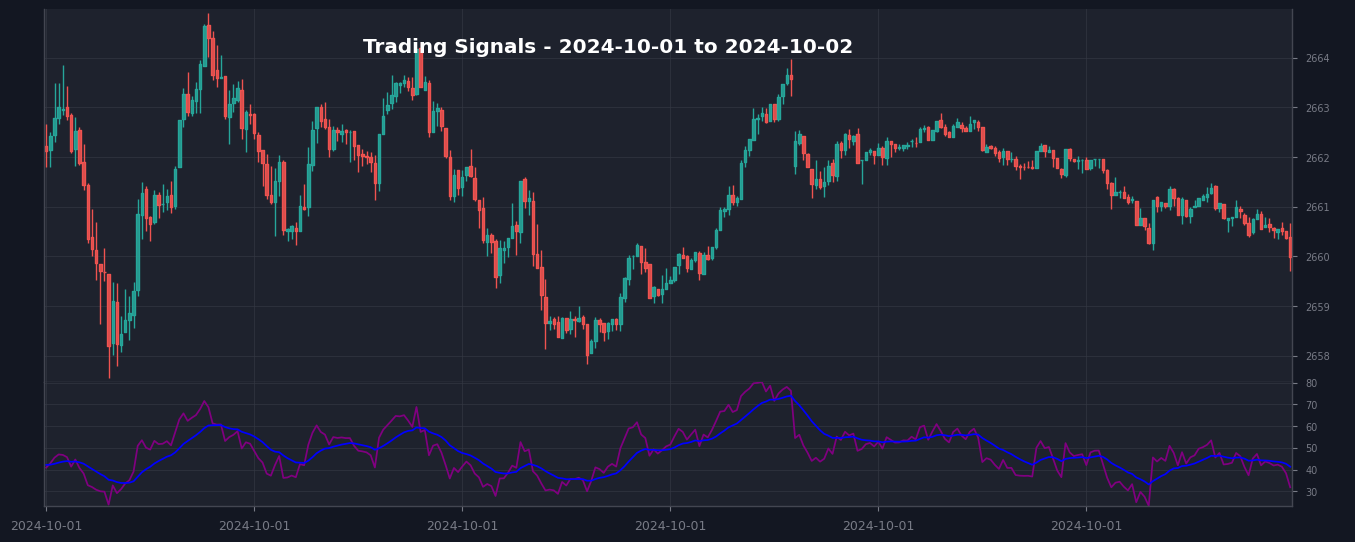

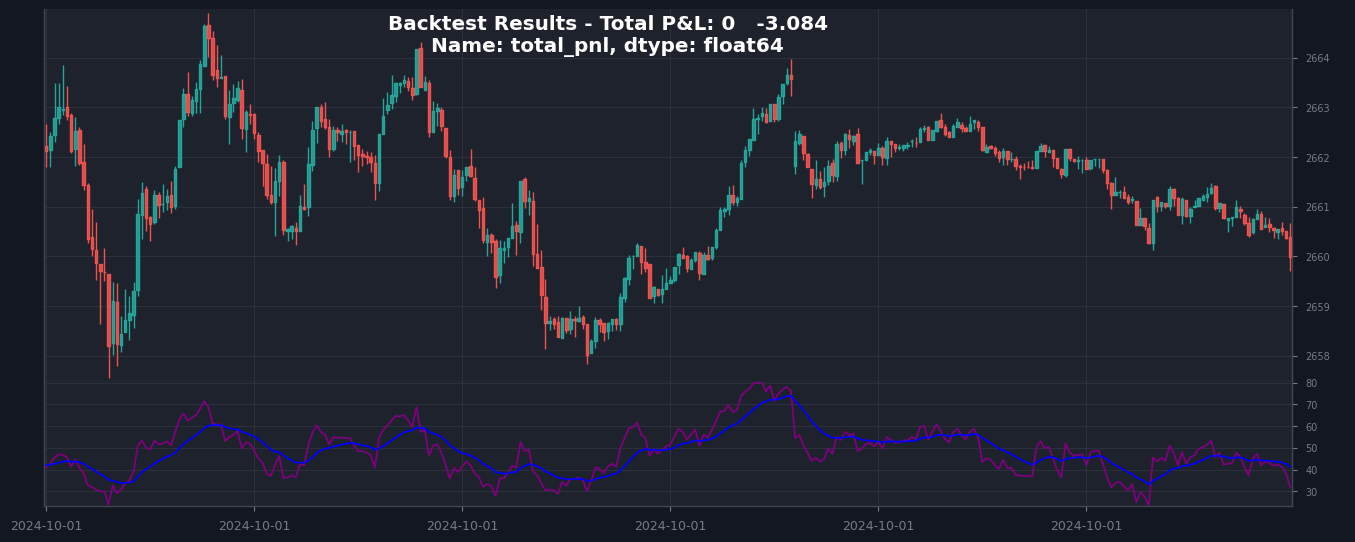

In [11]:
# Advanced Usage Examples
def create_custom_config_example() -> TradingConfig:
    """
    Example of creating a custom configuration for different market conditions.

    Returns:
        Customized trading configuration
    """
    return TradingConfig(
        # Aggressive scalping configuration
        rsi_period=9,           # Faster RSI
        ema_period=8,           # Faster EMA
        stop_loss_multiplier=0.5,  # Tighter stops
        take_profit_multiplier=1.5,  # Smaller targets

        # Extended analysis period
        start_date="2024-09-01",
        end_date="2024-10-31",

        # Higher resolution
        timeframe="1T",
        max_candles_display=300
    )


def run_multi_timeframe_analysis():
    """
    Example of running analysis across multiple timeframes.

    This demonstrates how to use the system for comprehensive
    multi-timeframe trading strategy development.
    """
    timeframes = ["1T", "5T", "15T", "1H"]
    results_by_timeframe = {}

    for tf in timeframes:
        logger.info(f"Analyzing timeframe: {tf}")

        config = TradingConfig(
            timeframe=tf,
            output_filename=f"results_{tf}.parquet"
        )

        try:
            orchestrator = TradingSystemOrchestrator(config)
            results = orchestrator.run_complete_analysis()
            results_by_timeframe[tf] = results['performance_summary']

        except Exception as e:
            logger.error(f"Analysis failed for {tf}: {e}")
            continue

    # Compare results across timeframes
    print(f"\n📊 Multi-Timeframe Analysis Results:")
    print("-" * 60)
    for tf, summary in results_by_timeframe.items():
        print(f"{tf:>4}: Return: {summary.get('total_return_pct', 0):>6.2f}% | "
              f"Trades: {summary.get('total_trades', 0):>3} | "
              f"Win Rate: {summary.get('win_rate', 0)*100:>5.1f}%")


if __name__ == "__main__":
    """
    Entry point for the enterprise trading system.

    Uncomment different sections to run various analysis types:
    - Standard analysis
    - Custom configuration
    - Multi-timeframe analysis
    """

    # Standard analysis
    results = main()

    # Custom configuration example
    # custom_config = create_custom_config_example()
    # custom_orchestrator = TradingSystemOrchestrator(custom_config)
    # custom_results = custom_orchestrator.run_complete_analysis()

    # Multi-timeframe analysis
    # run_multi_timeframe_analysis()

In [18]:
# results.keys('processed_data')
dta = results['signals_data']

In [19]:
dta[dta['RSI_14_crossed_up_EMA_15'] == 1]

,Open,High,Low,Close,Volume,RSI_14,EMA_15,RSI_14_crossed_up_EMA_15
datetime,,,,,,,,
2024-10-01 00:29:00,2635.811,2636.393,2635.681,2636.350,74,60.865915,54.885116,1
2024-10-01 00:43:00,2634.766,2635.196,2634.709,2635.029,65,44.064076,43.589576,1
2024-10-01 00:54:00,2636.092,2636.312,2635.567,2636.312,87,56.128847,53.759728,1
2024-10-01 01:03:00,2636.160,2636.662,2636.042,2636.662,83,57.950228,54.301105,1
2024-10-01 01:07:00,2636.503,2636.984,2636.459,2636.856,84,58.716873,55.319497,1
...,...,...,...,...,...,...,...,...
2024-10-01 23:12:00,2661.773,2661.941,2661.743,2661.941,39,47.911217,45.623207,1
2024-10-01 23:27:00,2660.276,2661.130,2660.137,2661.130,71,45.576686,34.722063,1
2024-10-01 23:43:00,2660.981,2661.076,2660.889,2661.071,42,47.656352,46.427038,1


In [ ]:
results['final_data']
# results['signal_array']
# results['backtest']
# results['charts']
# results['performance_summary']

In [12]:
"""
Enterprise Trading System - Usage Documentation
===============================================

Basic Usage:
-----------
```python
from enterprise_trading_system import TradingSystemOrchestrator, TradingConfig

# Create configuration
config = TradingConfig(
    rsi_period=14,
    ema_period=15,
    start_date="2024-10-01",
    end_date="2024-10-02"
)

# Run analysis
orchestrator = TradingSystemOrchestrator(config)
results = orchestrator.run_complete_analysis()

# Display results
orchestrator.display_performance_report(results)
```

Advanced Configuration:
----------------------
```python
# High-frequency trading setup
hft_config = TradingConfig(
    timeframe="30S",
    rsi_period=9,
    ema_period=6,
    stop_loss_multiplier=0.3,
    take_profit_multiplier=0.9
)

# Swing trading setup
swing_config = TradingConfig(
    timeframe="1H",
    rsi_period=21,
    ema_period=34,
    stop_loss_multiplier=2.0,
    take_profit_multiplier=4.0
)
```

Custom Analysis:
---------------
```python
# Access individual components
processor = DataProcessor(config)
data = processor.load_and_prepare_data()

generator = SignalGenerator(config)
signals = generator.generate_rsi_ema_signals(data)

visualizer = TradingVisualizer(config)
fig, axes = visualizer.create_comprehensive_chart(signals)
```

Error Handling:
--------------
All components include comprehensive error handling with detailed logging.
Check logs for debugging information if analysis fails.

Performance Considerations:
--------------------------
- Use max_candles_display to limit chart rendering for large datasets
- Consider data chunking for very large historical datasets
- Monitor memory usage with high-frequency data
- Use appropriate timeframes for your analysis requirements

Dependencies:
------------
- pandas >= 1.3.0
- numpy >= 1.21.0
- mplfinance >= 0.12.0
- matplotlib >= 3.5.0
- Custom modules: bktst, resampler, tafm, ChartterX5

For support and issues, check the logging output and validate your
data quality and configuration parameters.
"""

'\nEnterprise Trading System - Usage Documentation\n===============================================\n\nBasic Usage:\n-----------\n```python\nfrom enterprise_trading_system import TradingSystemOrchestrator, TradingConfig\n\n# Create configuration\nconfig = TradingConfig(\n    rsi_period=14,\n    ema_period=15,\n    start_date="2024-10-01",\n    end_date="2024-10-02"\n)\n\n# Run analysis\norchestrator = TradingSystemOrchestrator(config)\nresults = orchestrator.run_complete_analysis()\n\n# Display results\norchestrator.display_performance_report(results)\n```\n\nAdvanced Configuration:\n----------------------\n```python\n# High-frequency trading setup\nhft_config = TradingConfig(\n    timeframe="30S",\n    rsi_period=9,\n    ema_period=6,\n    stop_loss_multiplier=0.3,\n    take_profit_multiplier=0.9\n)\n\n# Swing trading setup\nswing_config = TradingConfig(\n    timeframe="1H",\n    rsi_period=21,\n    ema_period=34,\n    stop_loss_multiplier=2.0,\n    take_profit_multiplier=4.0\n)\n```\